
# S2orc (exploration, clustering & visualization)
---
---
For presenting some results we need to analyze (and rapidly compare) some of the methods we used untill now in order to discriminates between paper's `field_of_study` based on their `title` and `abstract`.
This notebook is an extention of some previous work done by Master's students from University of Florence (cite here).

## 1. Dataset
---

From each scientific paper we took the `title` and the `abstract`, as well as a property identifying the field in witch the article pertrains.
The dataset (only 1000 elements) has been selected randomly from a full-version of 80M papers from different fields.
The field of studies (that are called in the dataset `mag_field_of_study`) are the following:

| Field of study | All papers | Full text |
|----------------|------------|-----------|
| Medicine       | 12.8M      | 1.8M      |
| Biology        | 9.6M       | 1.6M      |
| Chemistry      | 8.7M       | 484k      |
| n/a            | 7.7M       | 583k      |
| Engineering    | 6.3M       | 228k      |
| Comp Sci       | 6.0M       | 580k      |
| Physics        | 4.9M       | 838k      |
| Mat Sci        | 4.6M       | 213k      |
| Math           | 3.9M       | 669k      |
| Psychology     | 3.4M       | 316k      |
| Economics      | 2.3M       | 198k      |
| Poli Sci       | 1.8M       | 69k       |
| Business       | 1.8M       | 94k       |
| Geology        | 1.8M       | 115k      |
| Sociology      | 1.6M       | 93k       |
| Geography      | 1.4M       | 58k       |
| Env Sci        | 766k       | 52k       |
| Art            | 700k       | 16k       |
| History        | 690k       | 22k       |
| Philosophy     | 384k       | 15k       |


Note for reproducibility: `data` is a `DatasetDict` object composed by `Dataset` object for every key (in `train`, `test`, `valid`):

```python
{
    "train": Dataset,
    "test" : Dataset,
    "valid": Dataset
}
```


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd

from thesis.utils.classes import DotDict
from sentence_transformers import SentenceTransformer
from thesis.utils.functions import fuse_datasets_splits, get_dict_args

from thesis.datasets.utils import getting_dataset_splitted

from thesis.utils.constants import (
    ARGS_PATH,
    ARGS_FILE,
    DICTIONARY_FIELD_NAMES,
    _factory_MODELS
)

from thesis.visualization.dim_reduction import pre_reduction, post_reduction
from thesis.visualization.clusterization import clusterization
from thesis.visualization.utils import visualization
from thesis.utils.functions import save_dict_to_json

For reasonable computation time, install Multicore-TSNE!


In [3]:
args = get_dict_args(os.path.join(ARGS_PATH, 'arguments.yaml'))

datasets = getting_dataset_splitted(args)
s2orc_chunk = fuse_datasets_splits(datasets)

args_ = DotDict(args)

type(args_) is dict: args_={'dataset_name': 's2orc', 'dataset_config_name': 'sample', 'seed': '1234', 'output_dir': '/home/vivoli/Thesis/output', 'num_train_epochs': '1', 'per_device_train_batch_size': '8', 'per_device_eval_batch_size': '8', 'max_seq_length': '512', 'model_name_or_path': 'allenai/scibert_scivocab_uncased', 'dataset_path': '/home/vivoli/Thesis/data', 'data': 'abstract', 'target': 'title', 'classes': 'mag_field_of_study', 'idxs': '0', 'zipped': True, 'mag_field_of_study': '', 'keep_none_papers': False, 'keep_unused_columns': False, 'run_name': 'scibert-s2orc', 'run_number': '0', 'run_iteration': '0', 'verbose': False, 'debug_log': False, 'time': False, 'callbacks': 'WandbCallback,CometCallback,TensorBoardCallback', 'fields': 'abstract', 'model_name': 'distilbert-base-nli-mean-tokens', 'pre_alg': 'umap', 'pre_n_neighbors': 15, 'pre_metric': 'cosine', 'pre_n_components': 50, 'pre_perplexity': 30.0, 'clustering_alg': 'kmeans', 'n_clusters': 10, 'min_cluster_size': 5, 'metri

In [4]:
dict_len = {}
for length in [len(mag) for mag in s2orc_chunk['mag_field_of_study']]:
    dict_len[length] = dict_len.get(length, 0) + 1
print(dict_len)

{1: 435, 2: 60, 3: 4}


### 1.3 Save and load the Dataset
---

In [5]:
s2orc_chunk

Dataset({
    features: ['abstract', 'title', 'mag_field_of_study'],
    num_rows: 499
})

## 2. Embeddings
___

Here we test multiple embedding BERT-based networks and cluster those embeddings with multiple clustering algorithms. Once we got the clusters we can visualize them using various dimentionality reduction algorithms.

In [6]:
from sentence_transformers import SentenceTransformer

### 2.2 Clustering
---

# VISUAL pipeline
---

In [7]:
args_

{'dataset_name': 's2orc',
 'dataset_config_name': 'sample',
 'seed': '1234',
 'output_dir': '/home/vivoli/Thesis/output',
 'num_train_epochs': '1',
 'per_device_train_batch_size': '8',
 'per_device_eval_batch_size': '8',
 'max_seq_length': '512',
 'model_name_or_path': 'allenai/scibert_scivocab_uncased',
 'dataset_path': '/home/vivoli/Thesis/data',
 'data': 'abstract',
 'target': 'title',
 'classes': 'mag_field_of_study',
 'idxs': '0',
 'zipped': True,
 'mag_field_of_study': '',
 'keep_none_papers': False,
 'keep_unused_columns': False,
 'run_name': 'scibert-s2orc',
 'run_number': '0',
 'run_iteration': '0',
 'verbose': False,
 'debug_log': False,
 'time': False,
 'callbacks': 'WandbCallback,CometCallback,TensorBoardCallback',
 'fields': 'abstract',
 'model_name': 'distilbert-base-nli-mean-tokens',
 'pre_alg': 'umap',
 'pre_n_neighbors': 15,
 'pre_metric': 'cosine',
 'pre_n_components': 50,
 'pre_perplexity': 30.0,
 'clustering_alg': 'kmeans',
 'n_clusters': 10,
 'min_cluster_size': 5,


[ BASE EMB ]: (499, 768)   | distilbert-base-nli-mean-tokens on abstract
[ PRE  EMB ]: (499, 50)   | umap
[ labels   ]: (499,)       | kmeans
[ POST EMB ]: (499,), (499,) | umap
[ pic  EMB ]: d:19-05-2021-16-38-48_Fie::abstract_Net::distilbert-base-nli-mean-tokens_PREa::umap:15:50:cosine_Clu::kmeans:10_POSTa::umap:15:2:cosine:0.0_.png


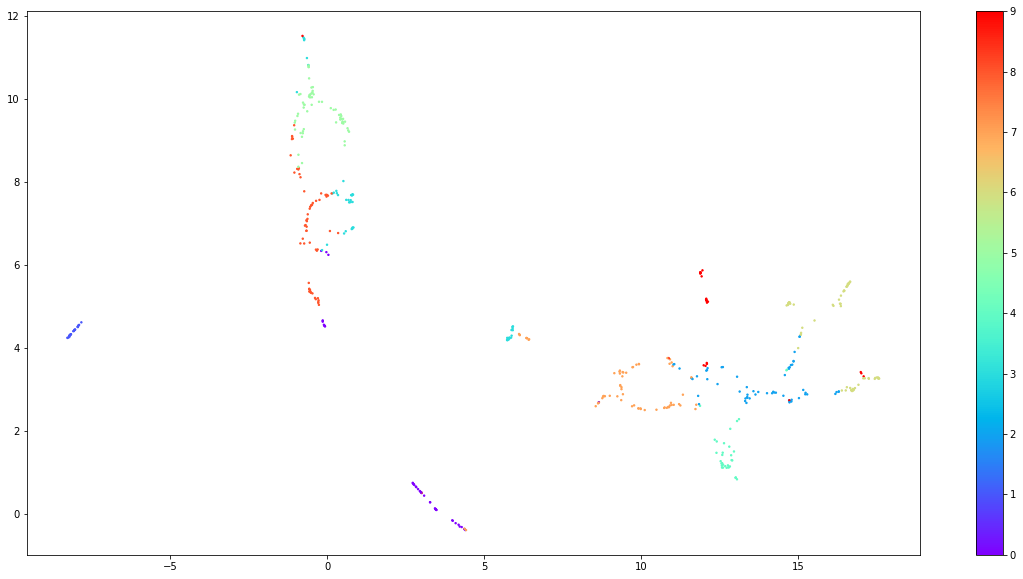

In [8]:
def embedd(args):
    model = SentenceTransformer(args.model_name)
    embeddings = model.encode(
        s2orc_chunk[args.fields], show_progress_bar=True)
    return embeddings

embeddings = embedd(args_)
print(
    f"[ BASE EMB ]: {embeddings.shape}   | {args_.model_name} on {args_.fields}")

embeddings = pre_reduction(args_, embeddings)
print(f"[ PRE  EMB ]: {embeddings.shape}   | {args_.pre_alg}")

labels = clusterization(args_, embeddings)
print(f"[ labels   ]: {labels.shape}       | {args_.clustering_alg}")

x, y = post_reduction(args_, embeddings)
print(f"[ POST EMB ]: {x.shape}, {y.shape} | {args_.post_alg}")

name = visualization(args_,  x, y, labels)
print(f"[ pic  EMB ]: {name}")

In [9]:
clustered_sentences = [[] for i in range(len(set(labels)))]
for sentence_id, cluster_id in enumerate(labels):
    clustered_sentences[cluster_id].append(s2orc_chunk[args_.fields][sentence_id])


In [10]:
for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i)
    print(cluster[:10])
    print("")


Cluster  0
['With the advances in e-Sciences and the growing complexity of scientific analyses, more and more scientists and researchers are relying on workflow systems for process coordination, derivation automation, provenance tracking, and bookkeeping. While workflow systems have been in use for decades, it is unclear whether scientific workflows can or even should build on existing workflow technologies, or they require fundamentally new approaches. In this paper, we analyze the status and challenges of scientific workflows, investigate both existing technologies and emerging languages, platforms and systems, and identify the key challenges that must be addressed by workflow systems for e-science in the 21st century.', 'The conventional approaches to routing and bandwidth allocation, the two major components of traffic engineering, have proved insufficient to address QoS requirements of flows while optimizing utilization for complex communication networks. In this paper we consider

### 2.3 Topic Exploration
---
We aim to see what kind of topics are presents.

In [11]:
from typing import Dict

mag_field_dict: Dict = {
    "Medicine"             : 0,
    "Biology"              : 1,
    "Chemistry"            : 2,
    "null"                 : 3,  # n/a
    "Engineering"          : 4,
    "Computer Science"     : 5,
    "Physics"              : 6,
    "Materials Science"    : 7,
    "Mathematics"          : 8,
    "Psychology"           : 9,
    "Economics"            : 10,
    "Political Science"    : 11,
    "Business"             : 12,
    "Geology"              : 13,
    "Sociology"            : 14,
    "Geography"            : 15,
    "Environmental Science": 16,
    "Art"                  : 17,
    "History"              : 18,
    "Philosophy"           : 19
}

In [12]:
dataframe = {
    "mag": mag_field_dict.keys(),
    "all_count": [0 for _ in mag_field_dict.keys()]
}
for cluster_id in list(set(labels)):
    dataframe[f'cluster {cluster_id}'] = [0 for _ in mag_field_dict.keys()]

df = pd.DataFrame(dataframe)

In [13]:
for cluster_id, mag_list in zip(labels, s2orc_chunk['mag_field_of_study']):
     for mag in mag_list:
        df['all_count'][mag_field_dict[mag]] += 1
        df[f'cluster {cluster_id}'][mag_field_dict[mag]] += 1

/home/vivoli/miniconda3/envs/thesis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vivoli/miniconda3/envs/thesis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [22]:
df.append(df.sum(axis=0), ignore_index=True)

,mag,all_count,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,cluster 9
0,Medicine,91,6,5,2,27,0,13,4,7,27,0
1,Biology,77,2,2,1,18,1,38,3,5,7,0
2,Chemistry,68,0,3,3,8,0,10,31,6,6,1
3,null,0,0,0,0,0,0,0,0,0,0,0
4,Engineering,19,1,2,2,1,1,0,2,8,1,1
5,Computer Science,52,9,2,0,4,5,1,0,27,3,1
6,Physics,111,1,2,48,0,7,0,15,14,2,22
7,Materials Science,16,0,0,3,1,0,1,10,1,0,0
8,Mathematics,50,0,1,6,0,26,0,3,13,0,1
9,Psychology,25,3,3,0,7,0,0,0,3,9,0


mag          MedicineBiologyChemistrynullEngineeringCompute...
all_count                                                  567
cluster 0                                                   49
cluster 1                                                   25
cluster 2                                                   66
cluster 3                                                   66
cluster 4                                                   40
cluster 5                                                   70
cluster 6                                                   69
cluster 7                                                   85
cluster 8                                                   70
cluster 9                                                   27
dtype: object

### 2.4 Topic Creation
---
We explore how to generate topic from clustered `documents` (more precisely, from abstract/title/both).

#### c-TF-IDF

In [15]:
docs_df = pd.DataFrame(s2orc_chunk['abstract'], columns=["Doc"])
docs_df['Topic'] = labels
docs_df['Doc_ID'] = range(len(docs_df))
%time docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

CPU times: user 3.74 ms, sys: 0 ns, total: 3.74 ms
Wall time: 3.69 ms


In [16]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
%time tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(s2orc_chunk['abstract']))

CPU times: user 66.4 ms, sys: 3.61 ms, total: 70 ms
Wall time: 69.6 ms


/home/vivoli/miniconda3/envs/thesis/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


#### topic representation

In [17]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = np.round(np.asarray(tf_idf.T), 3)
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

%time top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
%time topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

CPU times: user 5.04 ms, sys: 71 µs, total: 5.11 ms
Wall time: 4.78 ms
CPU times: user 0 ns, sys: 2.02 ms, total: 2.02 ms
Wall time: 1.81 ms


,Topic,Size
7,7,70
6,6,64
8,8,64
5,5,62
2,2,60
3,3,49
0,0,45
4,4,34
9,9,27
1,1,24


The topic name-1 refers to all documents that did not have any topics assigned. The great thing about HDBSCAN is that not all documents are forced towards a certain cluster. If no cluster could be found, then it is simply an outlier.

We can see that topics 7, 43, 12, and 41 are the largest clusters that we could create. To view the words belonging to those topics, we can simply use the dictionarytop_n_words to access these topics:

In [18]:
pd.DataFrame.from_records(top_n_words)

,0,1,2,3,4,5,6,7,8,9
0,"(state, 0.015)","(丙子日錄, nan)","(stress, 0.015)","(cells, 0.014)","(graphs, 0.028)","(species, 0.012)","(metal, 0.016)","(information, 0.012)","(children, 0.013)","(galaxy, 0.021)"
1,"(trust, 0.014)","(establish, nan)","(wave, 0.012)","(protein, 0.014)","(functions, 0.022)","(odor, 0.011)","(formation, 0.012)","(based, 0.01)","(patients, 0.012)","(radio, 0.021)"
2,"(tax, 0.013)","(essential, nan)","(temperature, 0.012)","(apoptosis, 0.012)","(graph, 0.021)","(rice, 0.009)","(reduction, 0.01)","(method, 0.009)","(survival, 0.011)","(emission, 0.021)"
3,"(sport, 0.01)","(essays, nan)","(interaction, 0.011)","(ephb4, 0.011)","(mixing, 0.02)","(increased, 0.009)","(nanoparticles, 0.01)","(proposed, 0.009)","(risk, 0.01)","(galaxies, 0.017)"
4,"(use, 0.01)","(especially, nan)","(photon, 0.011)","(hand, 0.011)","(paper, 0.017)","(weight, 0.009)","(temperature, 0.009)","(network, 0.009)","(pts, 0.01)","(light, 0.016)"
5,"(housing, 0.01)","(esi, nan)","(heat, 0.011)","(pc7, 0.01)","(predicates, 0.016)","(number, 0.009)","(catalysis, 0.009)","(quantum, 0.009)","(group, 0.009)","(ray, 0.015)"
6,"(sciences, 0.01)","(escorted, nan)","(14c, 0.011)","(search, 0.01)","(setae, 0.016)","(water, 0.009)","(catalyst, 0.009)","(algorithm, 0.008)","(students, 0.008)","(catalog, 0.014)"
7,"(sales, 0.01)","(escherichia, nan)","(magnetic, 0.01)","(tumors, 0.01)","(relations, 0.015)","(plants, 0.008)","(hydrogenation, 0.009)","(estimation, 0.008)","(women, 0.008)","(data, 0.014)"
8,"(poor, 0.009)","(escaped, nan)","(lambda, 0.01)","(signaling, 0.009)","(time, 0.015)","(fish, 0.008)","(properties, 0.009)","(lip, 0.008)","(game, 0.008)","(velocity, 0.014)"
9,"(systems, 0.009)","(escape, nan)","(field, 0.01)","(x1, 0.009)","(method, 0.014)","(13, 0.008)","(au, 0.009)","(optimization, 0.008)","(lds, 0.007)","(cosmic, 0.013)"


In [19]:
for topic in range(len(top_n_words)):
    print(pd.DataFrame([x[0] for x in top_n_words[topic][:10]]))
    print('\n\n')

          0
0     state
1     trust
2       tax
3     sport
4       use
5   housing
6  sciences
7     sales
8      poor
9   systems



             0
0         丙子日錄
1    establish
2    essential
3       essays
4   especially
5          esi
6     escorted
7  escherichia
8      escaped
9       escape



             0
0       stress
1         wave
2  temperature
3  interaction
4       photon
5         heat
6          14c
7     magnetic
8       lambda
9        field



           0
0      cells
1    protein
2  apoptosis
3      ephb4
4       hand
5        pc7
6     search
7     tumors
8  signaling
9         x1



            0
0      graphs
1   functions
2       graph
3      mixing
4       paper
5  predicates
6       setae
7   relations
8        time
9      method



           0
0    species
1       odor
2       rice
3  increased
4     weight
5     number
6      water
7     plants
8       fish
9         13



               0
0          metal
1      formation
2      reduction
3  nanoparti